In [13]:
import torch.nn as nn
import  image_loader as il
import visualize as vs
import gain as gn
from torchvision import models
from torch.utils.data import DataLoader

In [14]:
alex = models.alexnet(pretrained=True)
print(alex)
num_features = alex.classifier[6].in_features
alex.classifier[6] = nn.Linear(num_features, 5) # output labels
last_registred_layer= "features.10"

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
loader = il.DatasetLoader.initial()
train = loader.load_tensors(0, 150)
test = loader.load_tensors(400, 450)

train_set = DataLoader(il.ImageDataset(train), batch_size=1, shuffle=True, num_workers=4)
test_set = DataLoader(il.ImageDataset(test), batch_size=1, shuffle=True, num_workers=4)

In [30]:
gain_network = gn.GAIN(alex, last_registred_layer, gpu=True)

current_model, best_model_w = gain_network.train(train_set, 20)
best_model_m = alex.load_state_dict(best_model_w)

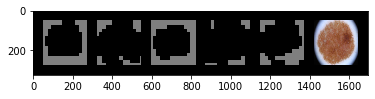

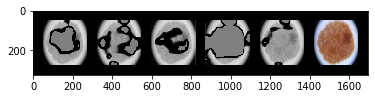

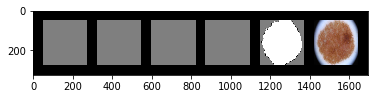

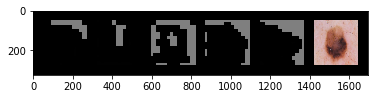

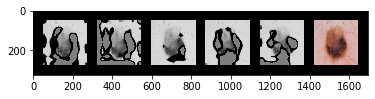

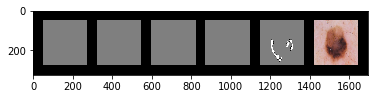

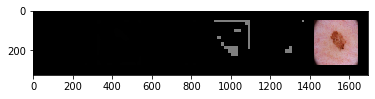

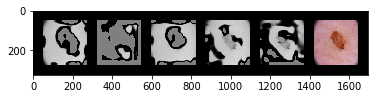

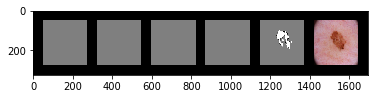

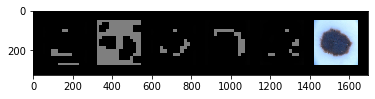

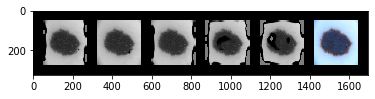

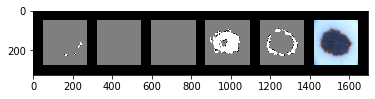

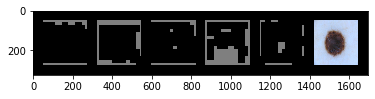

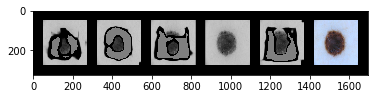

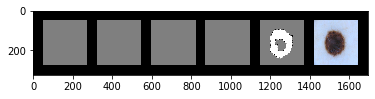

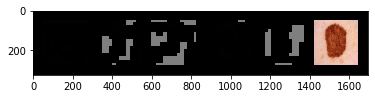

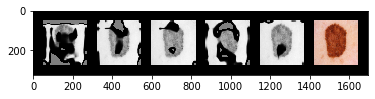

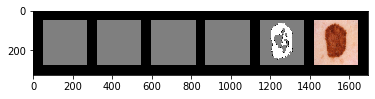

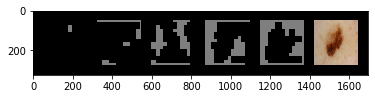

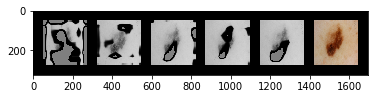

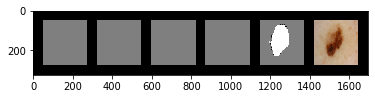

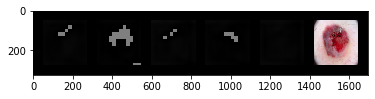

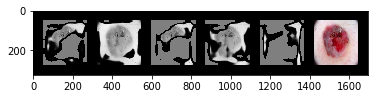

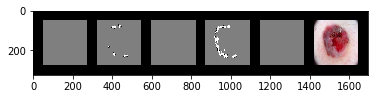

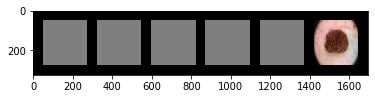

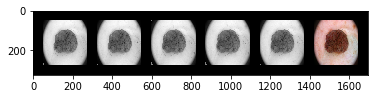

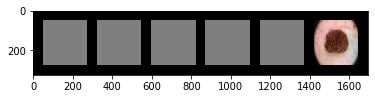

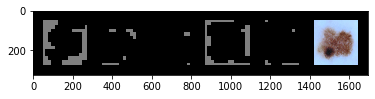

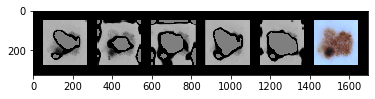

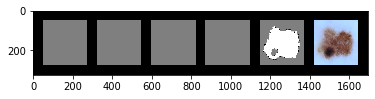

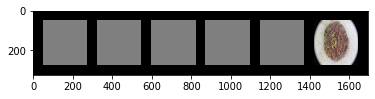

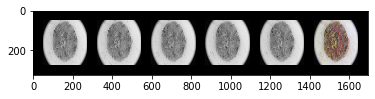

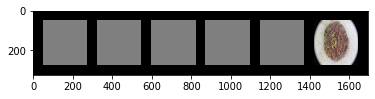

<Figure size 432x288 with 0 Axes>

In [32]:
for idx, (inputs, segments, labels) in enumerate(train_set):
    if idx > 10:
        continue
    inputs = inputs[0].to('cuda')
    labels = labels[0].to('cuda')
    segments = segments[0].to('cuda')
    _, _, _, _, a_c, i_start = gain_network.forward(current_model, inputs, segments, labels)
    a_c = a_c.cpu()
    i_start = i_start.cpu()
    inputs = inputs.cpu()
    vs.visualize_tensor(a_c, inputs)
    vs.visualize_tensor(i_start, inputs)
    vs.visualize_tensor(segments, inputs)